In [337]:
import glob
import xarray as xr
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import sys


#Functions

def get_global_weights():
    
     #Get the latitude weights from a special location
    r1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/Fig1_10year_Williams/'
    f = r1 + 'speedyoneWILLIAMS_L2_52_RN_10y/model_output00001.nc'
    df = xr.open_dataset(f)
    
    temperature = df.temperature
    #weights = np.cos(np.deg2rad(temperature.latitude))
    #weights.name = "weights"
    
    
    return temperature.latitude



    
def process_nc_file(f,true_latitude,counter):    
    
    #Get data 
    print('Opening file:', f)
    ds = xr.open_dataset(f)
    
        
    #Reset the latitude
    ds = ds.assign_coords(latitude=(true_latitude))
    #And covert longitude to long1
    ds = ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})
    
  
    
    
    #Just get the surface temperature
    temperature = ds.temperature
    surface_temperature = temperature[:,0]
    df = surface_temperature.to_dataframe().reset_index()
    
    df['weight']= np.cos(np.deg2rad(df.latitude))
    df['weighted_temperature']=  df.weight*df.temperature
    
    df_out = df.groupby(['latitude', 'longitude']).mean().reset_index() #i.e. average over time
    df_out['time'] = counter
    return df_out
    #can also select a single time e.g. df.query("forecast_period == '0 days'")

    
    


    
def RobinsonPlot(df,cmap):
    
    
    
    dftmp = df[['latitude','longitude','weighted_temperature']].copy() #Make a copy
    dfpivot = dftmp.pivot('longitude', 'latitude') #Pivot onto lon/lat

    #Extract data into arrays
    lat=dfpivot.columns.levels[1].values
    lon=dfpivot.index.values
    data=dfpivot.values.T


    #Setup plotting env
    fig = plt.figure(figsize=[20,10])
    ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))

    data, lon = add_cyclic_point(data, coord=lon) #https://stackoverflow.com/questions/56348136/white-line-in-contour-plot-in-cartopy-on-center-longitude
    ax.contourf(lon, lat, data,levels=50,transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap) #this has to be PlateCarree https://stackoverflow.com/questions/56761472/lack-of-projection-for-cartopy-contour
    ax.coastlines()
    plt.show()
    
    
    
    
def RobinsonPlotDev(df,cmap):
    
    
    
    dftmp = df[['latitude','longitude','weighted_temperature']].copy() #Make a copy
    dfpivot = dftmp.pivot('longitude', 'latitude') #Pivot onto lon/lat

    #Extract data into arrays
    lat=dfpivot.columns.levels[1].values
    lon=dfpivot.index.values
    data=dfpivot.values.T


    #Setup plotting env
    fig = plt.figure(figsize=[20,10])
    ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))
    
    
    #fig = plt.figure(figsize=[20,10])
    #gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    #print(gs)
    #ax = fig.add_subplot(gs[0], projection=ccrs.Robinson(central_longitude=0))
    #cax = fig.add_subplot(gs[1])
      
    
    
    
    
    
    
    

    data, lon = add_cyclic_point(data, coord=lon) #https://stackoverflow.com/questions/56348136/white-line-in-contour-plot-in-cartopy-on-center-longitude
    contourf_ = ax.contourf(lon, lat, data,levels=50,transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap) #this has to be PlateCarree https://stackoverflow.com/questions/56761472/lack-of-projection-for-cartopy-contour
    
    fig.colorbar(contourf_,orientation="horizontal",ax=ax,fraction=0.046, pad=0.04)
    print ('Limits:', min(data.flatten()), max(data.flatten()))
    #cbar = fig.colorbar(ax12, orientation="horizontal", ax=ax[:,2], pad=0.05)

    ax.coastlines()
    plt.show()
    
    
def average_ensemble_members(list_of_ensemble_member_files):
    
    #Get the true latitude, not subject to reduced precision
    true_latitude = get_global_weights()


    dfs = []

    counter = 0
    for f in list_of_ensemble_member_files: #for m0,m1,m2,m2,m4, 52RN
        #print(f)
        df = process_nc_file(f,true_latitude,counter) #counter can be thought of as a file ID here. We are going to average across files
        dfs.append(df)
        counter += 1

    df = pd.concat(dfs).reset_index(drop=True) # Bring together every ensemble member 100 year result into a single df
    return df.groupby(['latitude', 'longitude']).mean().reset_index() #average over each ensemble member


control_runs = sorted(glob.glob('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_control/*/model_output00098.nc')) #Control temperature after 100 years. Using 98 since m2 100 is missing?
competitor_runs = sorted(glob.glob('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m*/speedyone100yr_L2_52_RN_*/model_output00098.nc')) #Control temperature after 100 years. Using 98 since m2 100 is missing?



Limits: -0.7132769310237563 0.6212720481867109


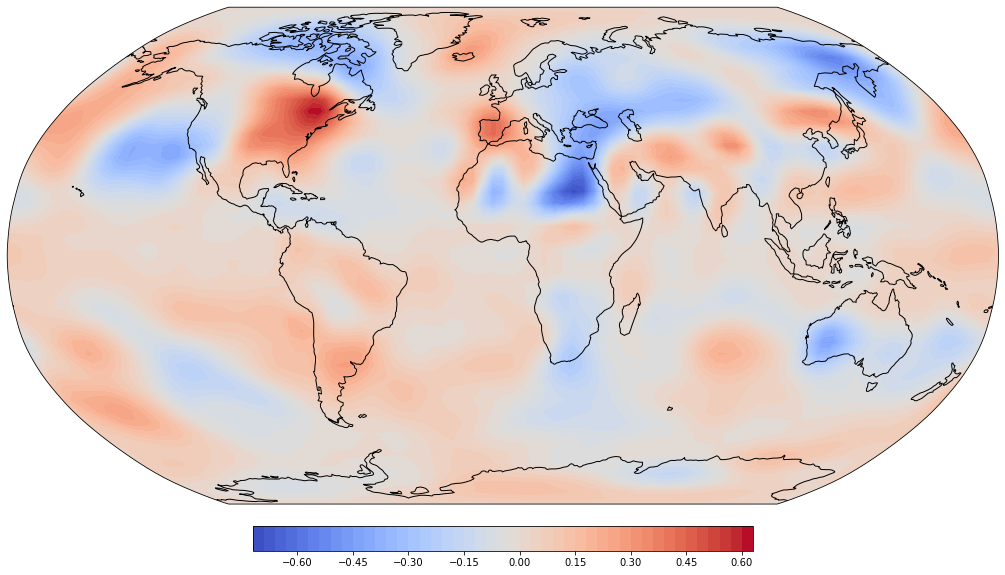

In [339]:
RobinsonPlotDev(subs,cmap=plt.cm.coolwarm)

Opening file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_control/speedyone100yr_L2_52_RN_m0/model_output00098.nc
Opening file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_control/speedyone100yr_L2_52_RN_m1/model_output00098.nc
Opening file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_control/speedyone100yr_L2_52_RN_m2/model_output00098.nc
Opening file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_control/speedyone100yr_L2_52_RN_m3/model_output00098.nc
Opening file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_control/speedyone100yr_L2_52_RN_m4/model_output00098.nc
Opening file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_52_RN_m5/model_output00098.nc
Opening file: /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_

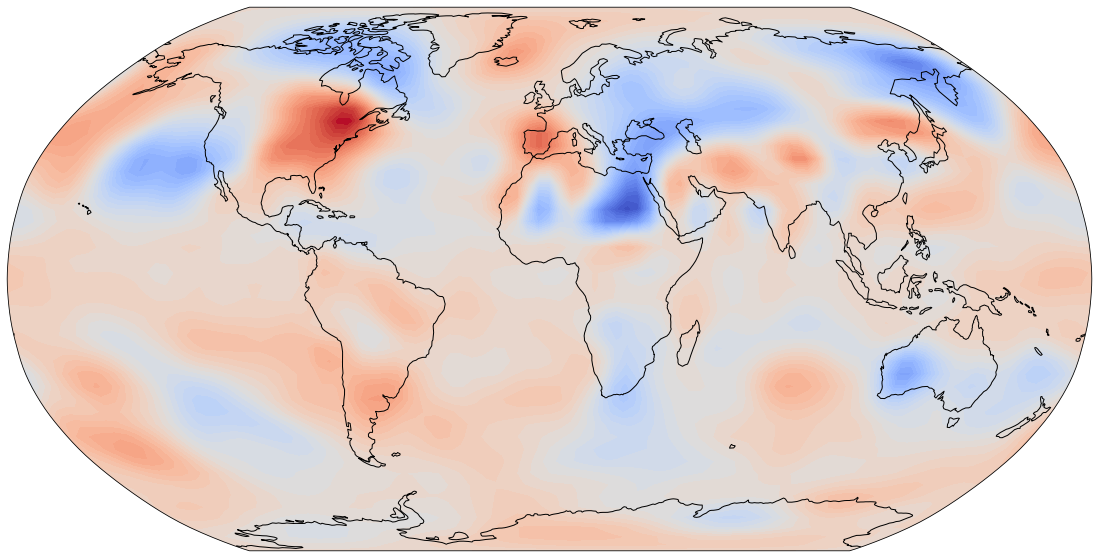

In [307]:
df_control= average_ensemble_members(control_runs)
df_competitor = average_ensemble_members(competitor_runs)

#Subtract one from other
subs = df_control.copy()
subs['weighted_temperature'] = df_control.weighted_temperature - df_competitor.weighted_temperature
RobinsonPlot(subs,cmap=plt.cm.coolwarm)

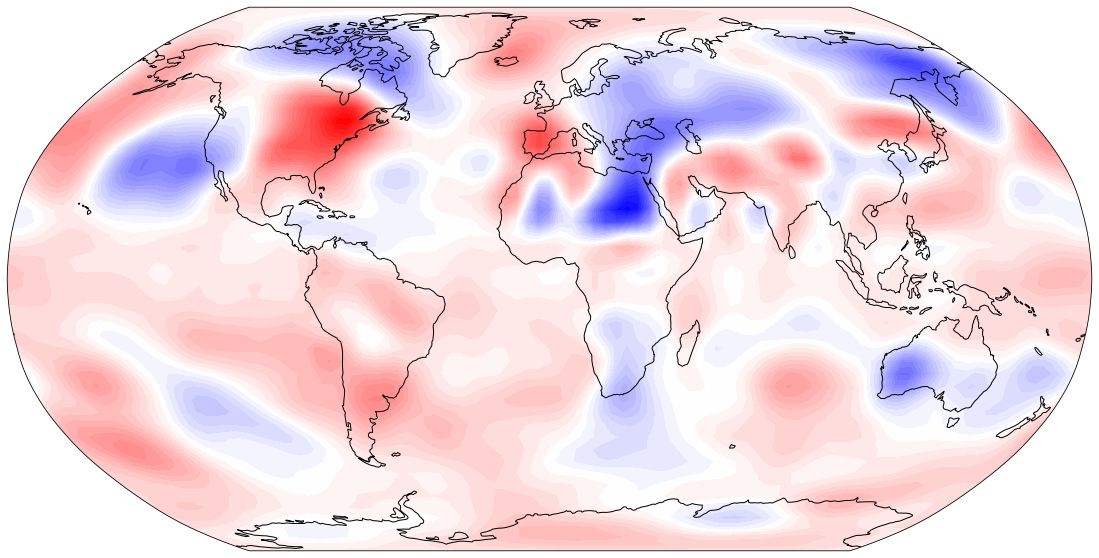

In [308]:
RobinsonPlot(subs,cmap=plt.cm.bwr)

In [298]:
display(df_control)
display(df_competitor)

,latitude,longitude,pressure,temperature,weight,weighted_temperature,time
0,-87.159095,-180.00,925.0,251.704831,0.049563,12.475206,2.0
1,-87.159095,-176.25,925.0,251.980650,0.049563,12.488877,2.0
2,-87.159095,-172.50,925.0,252.234482,0.049563,12.501457,2.0
3,-87.159095,-168.75,925.0,252.464705,0.049563,12.512868,2.0
4,-87.159095,-165.00,925.0,252.669166,0.049563,12.523001,2.0
...,...,...,...,...,...,...,...
4603,87.159095,161.25,925.0,259.432763,0.049563,12.858224,2.0
4604,87.159095,165.00,925.0,259.506420,0.049563,12.861875,2.0
4605,87.159095,168.75,925.0,259.583525,0.049563,12.865697,2.0
4606,87.159095,172.50,925.0,259.663483,0.049563,12.869660,2.0


,latitude,longitude,pressure,temperature,weight,weighted_temperature,time
0,-87.159095,-180.00,925.0,251.704831,0.049563,12.475206,2.0
1,-87.159095,-176.25,925.0,251.980650,0.049563,12.488877,2.0
2,-87.159095,-172.50,925.0,252.234482,0.049563,12.501457,2.0
3,-87.159095,-168.75,925.0,252.464705,0.049563,12.512868,2.0
4,-87.159095,-165.00,925.0,252.669166,0.049563,12.523001,2.0
...,...,...,...,...,...,...,...
4603,87.159095,161.25,925.0,259.432763,0.049563,12.858224,2.0
4604,87.159095,165.00,925.0,259.506420,0.049563,12.861875,2.0
4605,87.159095,168.75,925.0,259.583525,0.049563,12.865697,2.0
4606,87.159095,172.50,925.0,259.663483,0.049563,12.869660,2.0


In [299]:
subs

,latitude,longitude,pressure,temperature,weight,weighted_temperature,time
0,-87.159095,-180.00,925.0,251.704831,0.049563,0.0,2.0
1,-87.159095,-176.25,925.0,251.980650,0.049563,0.0,2.0
2,-87.159095,-172.50,925.0,252.234482,0.049563,0.0,2.0
3,-87.159095,-168.75,925.0,252.464705,0.049563,0.0,2.0
4,-87.159095,-165.00,925.0,252.669166,0.049563,0.0,2.0
...,...,...,...,...,...,...,...
4603,87.159095,161.25,925.0,259.432763,0.049563,0.0,2.0
4604,87.159095,165.00,925.0,259.506420,0.049563,0.0,2.0
4605,87.159095,168.75,925.0,259.583525,0.049563,0.0,2.0
4606,87.159095,172.50,925.0,259.663483,0.049563,0.0,2.0


In [292]:
df_competitor

,latitude,longitude,pressure,temperature,weight,weighted_temperature,time
0,-87.159095,-180.00,925.0,251.704831,0.049563,12.475206,2.0
1,-87.159095,-176.25,925.0,251.980650,0.049563,12.488877,2.0
2,-87.159095,-172.50,925.0,252.234482,0.049563,12.501457,2.0
3,-87.159095,-168.75,925.0,252.464705,0.049563,12.512868,2.0
4,-87.159095,-165.00,925.0,252.669166,0.049563,12.523001,2.0
...,...,...,...,...,...,...,...
4603,87.159095,161.25,925.0,259.432763,0.049563,12.858224,2.0
4604,87.159095,165.00,925.0,259.506420,0.049563,12.861875,2.0
4605,87.159095,168.75,925.0,259.583525,0.049563,12.865697,2.0
4606,87.159095,172.50,925.0,259.663483,0.049563,12.869660,2.0


In [282]:
df_control_averaged = df_control.groupby(['latitude', 'longitude']).mean().reset_index()


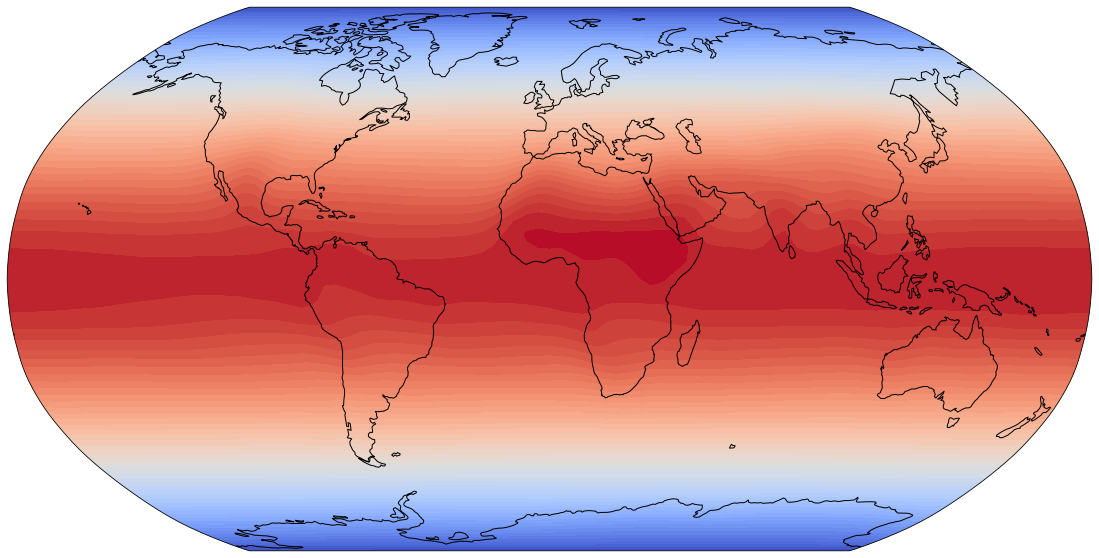

In [284]:
RobinsonPlot(df_control_averaged,cmap=plt.cm.coolwarm)

In [ ]:







#     print(d)
#     nc_files = sorted(glob.glob(d+'/model_output*.nc'))
    
#     dfs = []
#     counter = 1
#     for n in tqdm(nc_files[0:2]): #for every yearly file
#         df = process_nc_file(f,true_latitude,counter) #weighted average annual surface temperature for every grid point
#         
    
#     d
#     display(df_m)
#     display(df_m.groupby(['latitude', 'longitude']).mean().reset_index()) #i.e. take yearly averages, and then average them
#     sys.exit()
    
    
#print (control_dirs)

#df1 = process_nc_file(f1,true_latitude,counter=1)

#display(df1)


#t2 =
#f2 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_52_RN_m6/model_output00002.nc'
#df2 = process_nc_file(f2,true_latitude,t2)


#subs = df2.copy()
#subs['weighted_temperature'] = df2.weighted_temperature - df1.weighted_temperature
#RobinsonPlot(subs,cmap=plt.cm.bwr)
#RobinsonPlot(df1,cmap=plt.cm.coolwarm)
#RobinsonPlot(subs,cmap=plt.cm.seismic)

In [ ]:


#Get the true latitude, not subject to reduced precision
true_latitude = get_global_weights()

#Process a single nc file using latitude values for weights, at a single time
f1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_52_RN_m6/model_output00001.nc'


dfs = []

control_dirs = sorted(glob.glob('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_control/*'))
for d in control_dirs: #for m0,m1,m2,m2,m4, 52RN
    m = d.split('_')[-1]
    print(d)
    nc_files = sorted(glob.glob(d+'/model_output*.nc'))
    
    dfs = []
    counter = 1
    for n in tqdm(nc_files[0:2]): #for every yearly file
        df = process_nc_file(f,true_latitude,counter) #weighted average annual surface temperature for every grid point
        dfs.append(df)
        counter += 1
    
    df_m = pd.concat(dfs).reset_index(drop=True) # Bring together every year into a single df
    display(df_m)
    display(df_m.groupby(['latitude', 'longitude']).mean().reset_index()) #i.e. take yearly averages, and then average them
    sys.exit()
    
    
#print (control_dirs)

#df1 = process_nc_file(f1,true_latitude,counter=1)

#display(df1)


#t2 =
#f2 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m6/speedyone100yr_L2_52_RN_m6/model_output00002.nc'
#df2 = process_nc_file(f2,true_latitude,t2)


#subs = df2.copy()
#subs['weighted_temperature'] = df2.weighted_temperature - df1.weighted_temperature
#RobinsonPlot(subs,cmap=plt.cm.bwr)
#RobinsonPlot(df1,cmap=plt.cm.coolwarm)
#RobinsonPlot(subs,cmap=plt.cm.seismic)


print ('Done')

In [259]:
from tqdm.notebook import tqdm


In [232]:
subs = df2-df1
  
dftmp = subs[['latitude','longitude','weighted_temperature']].copy() #Make a copy
display(dftmp)
dfpivot = dftmp.pivot('longitude', 'latitude') #Pivot onto lon/lat

    #Extract data into arrays

,latitude,longitude,weighted_temperature
0,0.0,0.0,0.057537
1,0.0,0.0,0.057414
2,0.0,0.0,0.057232
3,0.0,0.0,0.057030
4,0.0,0.0,0.056851
...,...,...,...
4603,0.0,0.0,1.136822
4604,0.0,0.0,1.143858
4605,0.0,0.0,1.150172
4606,0.0,0.0,1.155884


In [ ]:

#Iterate over all directories
#df = process_all_data(header_directories,weights,true_lat)


In [94]:
df

,forecast_period,latitude,longitude,pressure,temperature,weight,weighted_temperature
0,0 days,87.159095,0.00,925.0,260.618908,0.049563,12.917013
1,0 days,87.159095,3.75,925.0,260.593622,0.049563,12.915760
2,0 days,87.159095,7.50,925.0,260.561488,0.049563,12.914167
3,0 days,87.159095,11.25,925.0,260.522570,0.049563,12.912238
4,0 days,87.159095,15.00,925.0,260.477152,0.049563,12.909987
...,...,...,...,...,...,...,...
4603,0 days,-87.159095,-18.75,925.0,236.054762,0.049563,11.699544
4604,0 days,-87.159095,-15.00,925.0,235.834605,0.049563,11.688633
4605,0 days,-87.159095,-11.25,925.0,235.613579,0.049563,11.677678
4606,0 days,-87.159095,-7.50,925.0,235.389892,0.049563,11.666591


In [147]:

import pandas as pd
import json
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.colors as mc
import matplotlib.colorbar as cb 
import scipy.interpolate

from scipy.interpolate import interp1d

from scipy.interpolate import griddata
import matplotlib.tri as mtri


def plotter(df,cmap,title,markersize):
    
    """Scatter plot. Bit hacky. """

    x = df.longitude
    y = df.latitude
    z = df.weighted_temperature

    
    hdfpivot=df.pivot('x', 'y')
    
    #grid_x, grid_y = np.meshgrid(x, y)
    #grid_z0 = griddata((x,y), z, (grid_x, grid_y), method='cubic')

    
    
    

    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=0))
    cax = fig.add_subplot(gs[1])
    

    norm = mc.Normalize(vmin=df.weighted_temperature.min(), vmax=df.weighted_temperature.max())

    
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    
    #Plot it
    sc=ax.scatter(x,y,s=markersize,c=cmap(norm(z)),
                linewidths=1, alpha=.7)

    
    #Tidy up
    ax.axhline(70, c='0.5', linestyle='--')
    ax.axhline(-70, c='0.5', linestyle='--') #latitude cutoffs

    ax.set_title(title)    
    ax.coastlines()

    
    ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    ax.set_aspect('auto') #Force projection aspect ratio
    
    plt.show()
    
    
    
def plotterV2(df,cmap,title,markersize):
    
    
    #Setup figure and axes
    fig = plt.figure(figsize=[30,20])
    gs = GridSpec(1, 2, figure=fig, width_ratios=[50,1])
    ax = fig.add_subplot(gs[0], projection=ccrs.Robinson(central_longitude=0))
    cax = fig.add_subplot(gs[1])
   
    
    
    #Get data
    dflite = df[['latitude','longitude','weighted_temperature']].copy() #df.pivot('longitude', 'latitude')
    x = dflite.longitude
    y = dflite.latitude
    z = dflite.weighted_temperature
    
    
    ##CONTOURF PLOTTING METHOD
    hdfpivot = dflite.pivot('longitude', 'latitude')
    X=hdfpivot.columns.levels[1].values
    Y=hdfpivot.index.values
    Z=hdfpivot.values
    Xi,Yi = np.meshgrid(X, Y)
    ax.contourf(Yi, Xi, Z, alpha=0.6, cmap=cmap,levels=5)


    ax.coastlines()
    plt.show()
    
    
    
    
    
    
# def simple_plot(df):
    
 
# fig = plt.figure(num=None, figsize=(8, 6), dpi=80, edgecolor='k')

# ax = plt.axes(projection=ccrs.PlateCarree())

# ax.imshow(data.T, origin='lower', extent=[-180,180,-90,90], transform=ccrs.PlateCarree(),cmap='jet',vmin=0, vmax=1.0)

# ax.coastlines()

# plt.title("Plot a heatmap with cartopy in python", fontsize=12)

# plt.savefig("cartopy_heatmap_02.png", bbox_inches='tight', dpi=200)
    
    
    

In [ ]:
Robinson

-180.0 176.25 96
-87.15909455586285 87.15909455586285 48
(48,)
(96,)
(96, 48)


NameError: name 'tem' is not defined

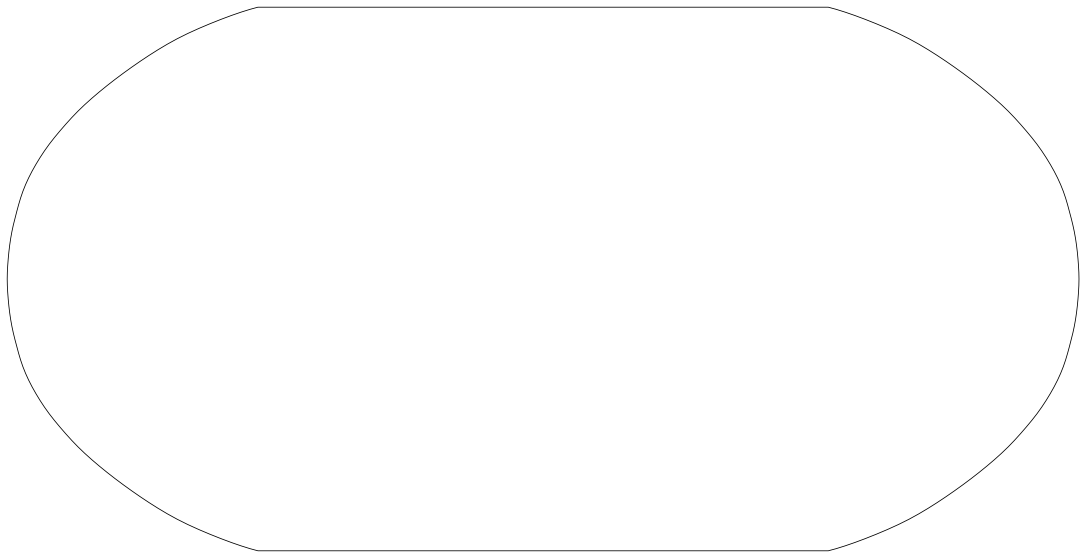

In [201]:
cmap=plt.cm.viridis
title='title'

fig = plt.figure(figsize=[20,10])
ax = plt.axes(projection=ccrs.Robinson(central_longitude=0))



from cartopy.util import add_cyclic_point


#Get data
dflite = df[['latitude','longitude','weighted_temperature']].copy() #df.pivot('longitude', 'latitude')
x = dflite.longitude
y = dflite.latitude
z = dflite.weighted_temperature

    
##CONTOURF PLOTTING METHOD
hdfpivot = dflite.pivot('longitude', 'latitude')
lats=hdfpivot.columns.levels[1].values
lons=hdfpivot.index.values
temperatures=hdfpivot.values

print(min(lons), max(lons),len(lons))
print(min(lats), max(lats),len(lats))



lats_i,lons_i = np.meshgrid(lats, lons)


# print (XX.shape)
# print (YY.shape)
# print (ZZ.shape)
# print (Xi.shape)
# print (Yi.shape)
#Z, Xi = add_cyclic_point(Z, coord=Xi)

print(lats.shape)
print(lons.shape)
print(temperatures.shape)
ax.contourf(lons, lats, tem,transform=ccrs.PlateCarree(central_longitude=0))


# ax.contourf(Y, X, Z, 60,
#             transform=ccrs.PlateCarree(central_longitude=0))
ax.scatter(x, y,
            transform=ccrs.PlateCarree(central_longitude=0))


#plt.scatter(Yi, Xi, Z, 60,
     #       transform=ccrs.PlateCarree(central_longitude=0))




ax.coastlines()

plt.show()
    

(96,)
(48,)
(48, 96)


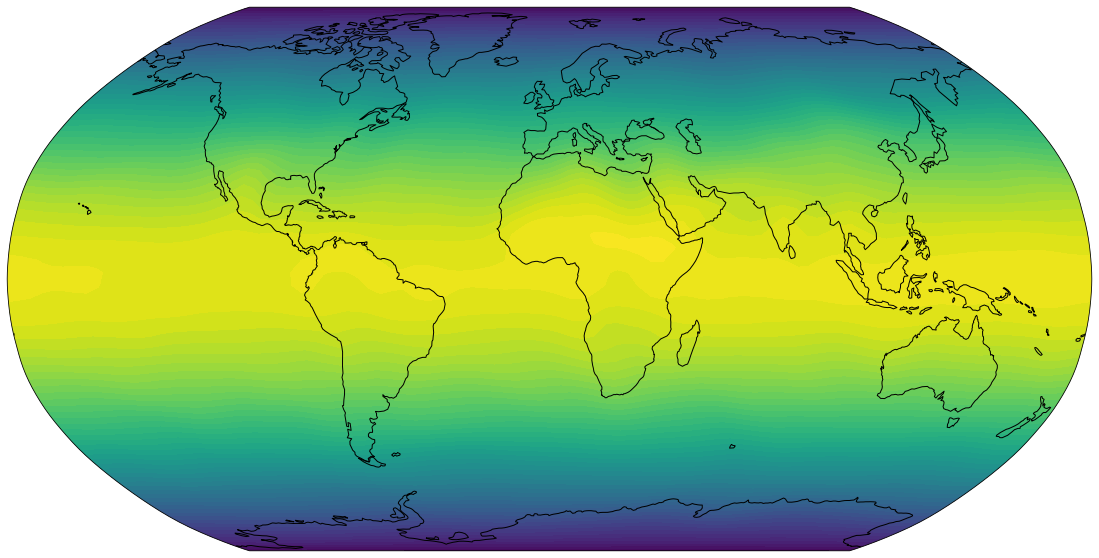

In [210]:



dflite = df[['latitude','longitude','weighted_temperature']].copy() #df.pivot('longitude', 'latitude')
hdfpivot = dflite.pivot('longitude', 'latitude')


lat=hdfpivot.columns.levels[1].values
lon=hdfpivot.index.values
data=hdfpivot.values.T





#lon = np.linspace(-180, 180, 96) #96 longiude values
#lat = np.linspace(-90, 90, 48) #48 latitude values
#data = np.zeros((48, 96)) #array shape (48,96)



fig = plt.figure(figsize=[20,10])
ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))


print(lon.shape)
print(lat.shape)
print(data.shape)

data, lon = add_cyclic_point(data, coord=lon)



ax.contourf(lon, lat, data,levels=50,transform=ccrs.PlateCarree(central_longitude=0))


ax.coastlines()
plt.show()


(96,)
(48,)
(48, 96)


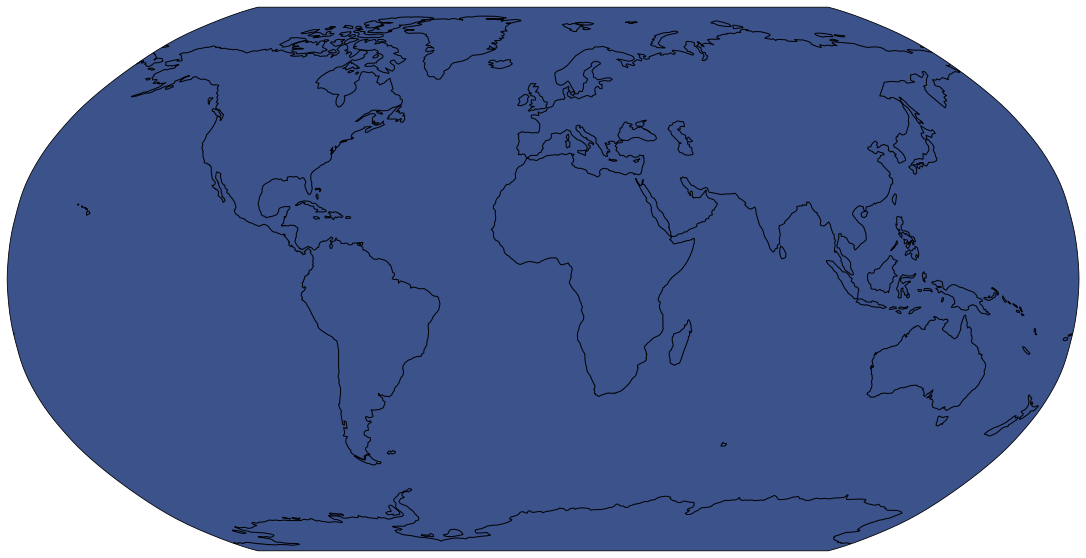

In [205]:
# lon = np.arange(0, 360, 1) #360 longiude values
# lat = np.arange(-90, 90, 1) #180 latitude values
# data = np.zeros((180, 360)) #array shape (180,360)


lon = np.linspace(-180, 180, 96) #96 longiude values
lat = np.linspace(-90, 90, 48) #48 latitude values
data = np.zeros((48, 96)) #array shape (48,96)



fig = plt.figure(figsize=[20,10])
ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))


print(lon.shape)
print(lat.shape)
print(data.shape)


#Z, Xi = add_cyclic_point(Z, coord=Xi)



ax.contourf(lon, lat, data,transform=ccrs.PlateCarree(central_longitude=0))


ax.coastlines()
plt.show()





In [189]:
import cartopy
help(cartopy)

Help on package cartopy:

NAME
    cartopy

DESCRIPTION
    # Copyright Cartopy Contributors
    #
    # This file is part of Cartopy and is released under the LGPL license.
    # See COPYING and COPYING.LESSER in the root of the repository for full
    # licensing details.

PACKAGE CONTENTS
    _epsg
    _version
    crs
    feature (package)
    geodesic
    img_transform
    io (package)
    mpl (package)
    tests (package)
    trace
    util
    vector_transform

DATA
    __document_these__ = ['config']
    config = {'cache_dir': '/tmp/cartopy_cache_dir', 'data_dir': '/home/k/...

VERSION
    0.20.2

FILE
    /home/k/kimpson/bin/conda/envs/workhorse/lib/python3.7/site-packages/cartopy/__init__.py




In [187]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from ccrs.waves import sample_data

fig = plt.figure(figsize=[20,10])
ax = plt.axes(projection=ccrs.Mercator())

lons, lats, data = sample_data(shape=(20, 40))

ax.contourf(lons, lats, data, transform=ccrs.PlateCarree())

ax.coastlines()
ax.gridlines()

plt.show()

ModuleNotFoundError: No module named 'ccrs'

In [133]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [134]:
# def plot_ERA(ds,q):
#     world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#     df = ds.to_dataframe()

#     ax=world.boundary.plot(figsize=(24,12))

#     #Create geopandas
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

    #Plot it
#    gdf.plot(ax=ax,column=q, cmap='plasma', legend=True,markersize=1)


AttributeError: 'GeoDataFrame' object has no attribute 'contourf'

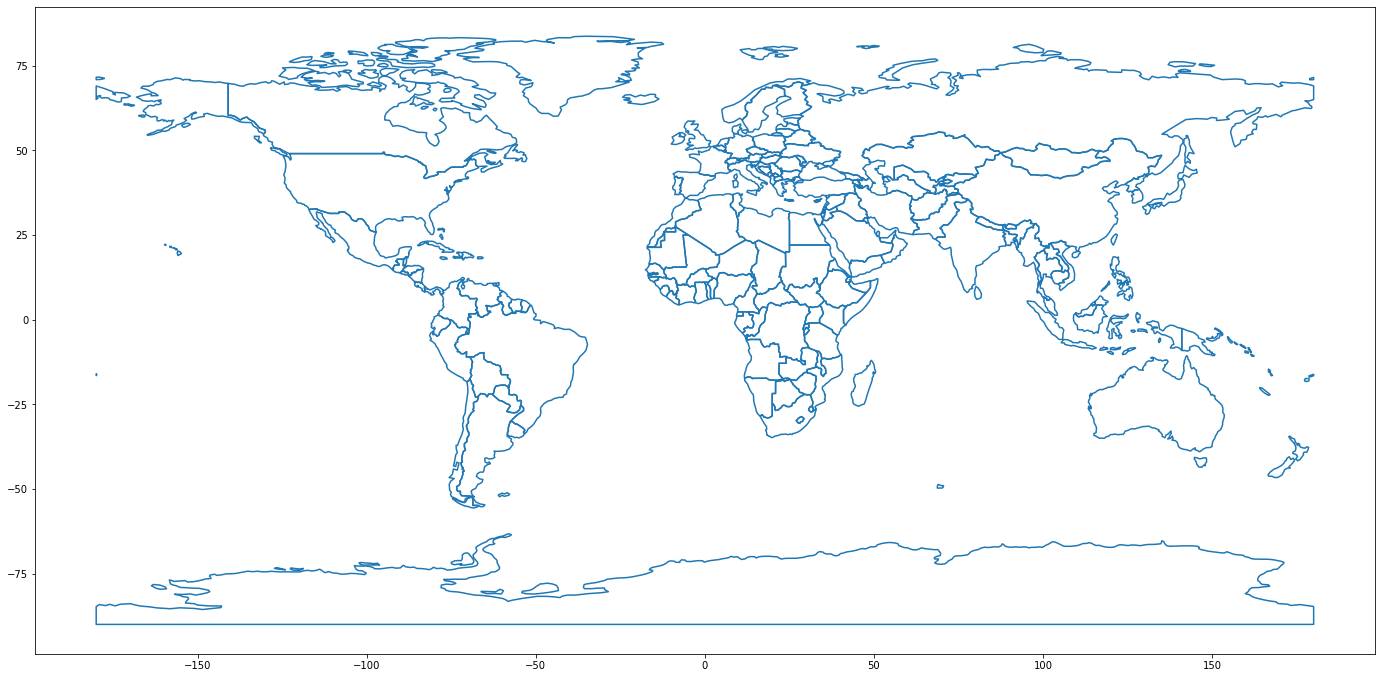

In [138]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax=world.boundary.plot(figsize=(24,12))
gdf.contourf(ax=ax,column='weighted_temperature',cmap='plasma',legend=True)

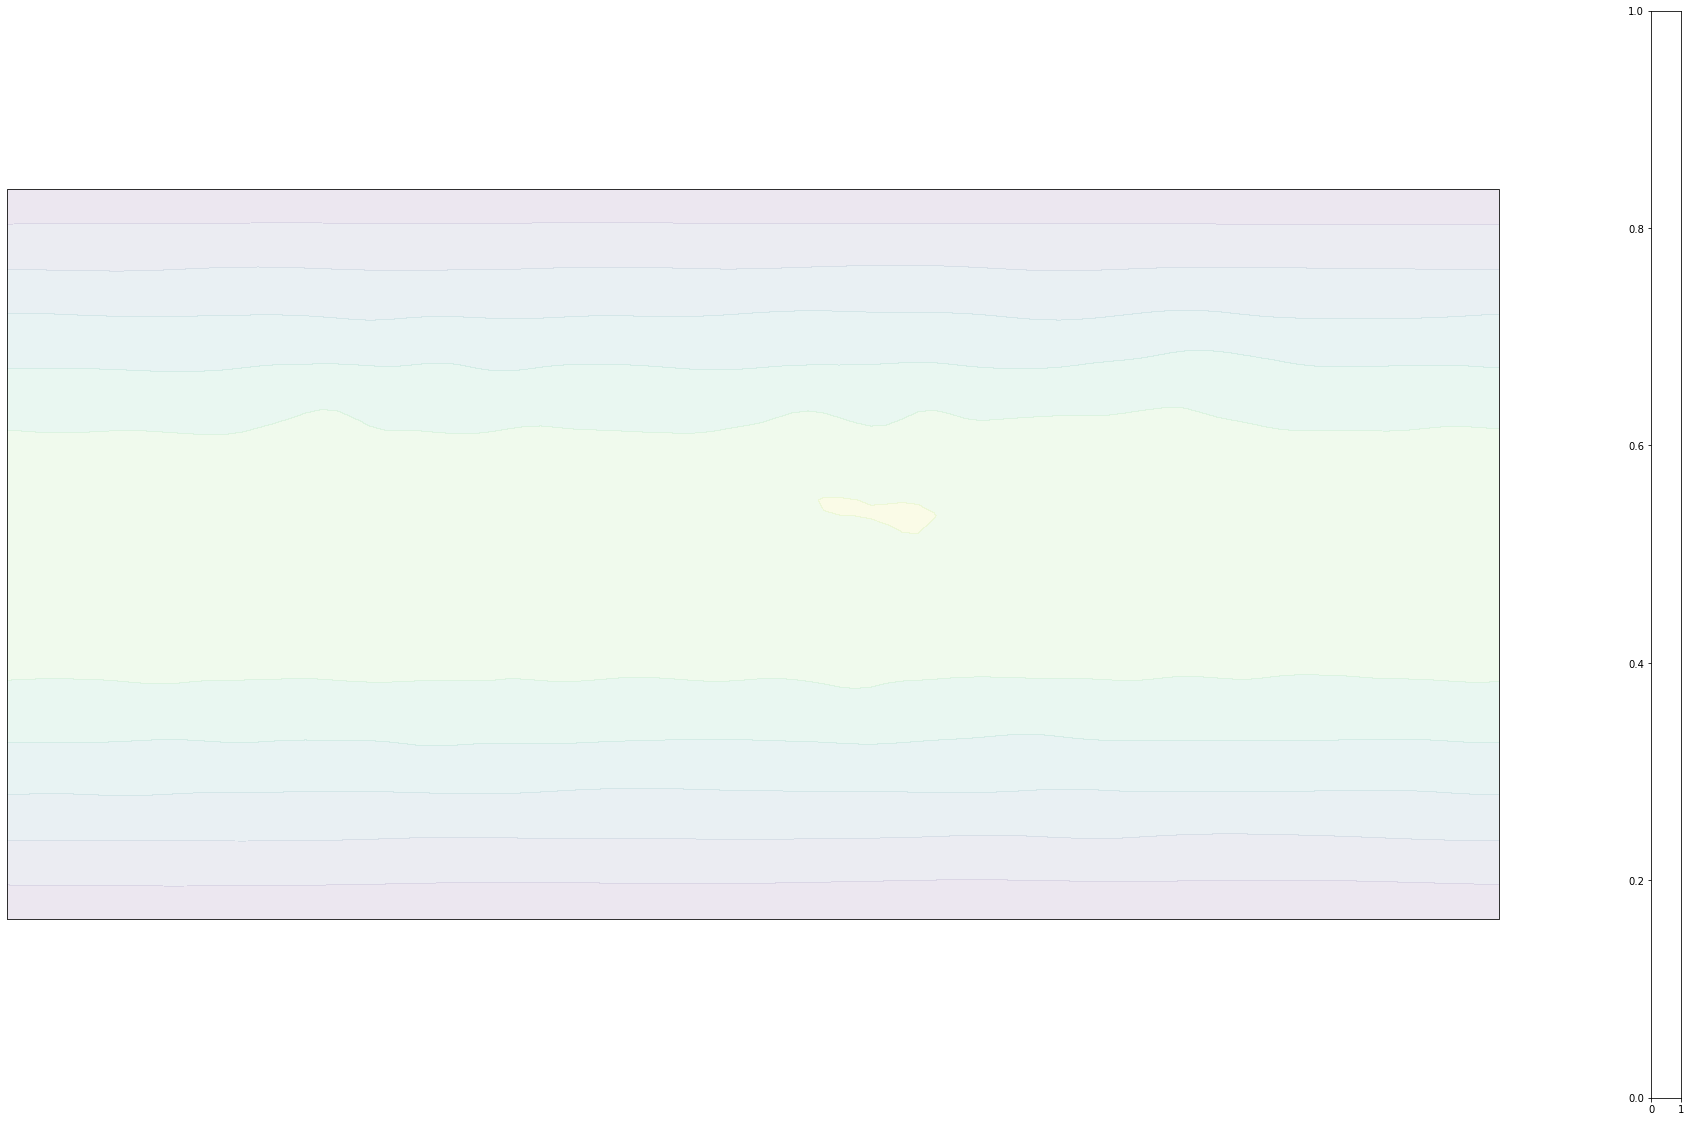

In [140]:
plotterV2(df,cmap=plt.cm.viridis,title='title',markersize=200)

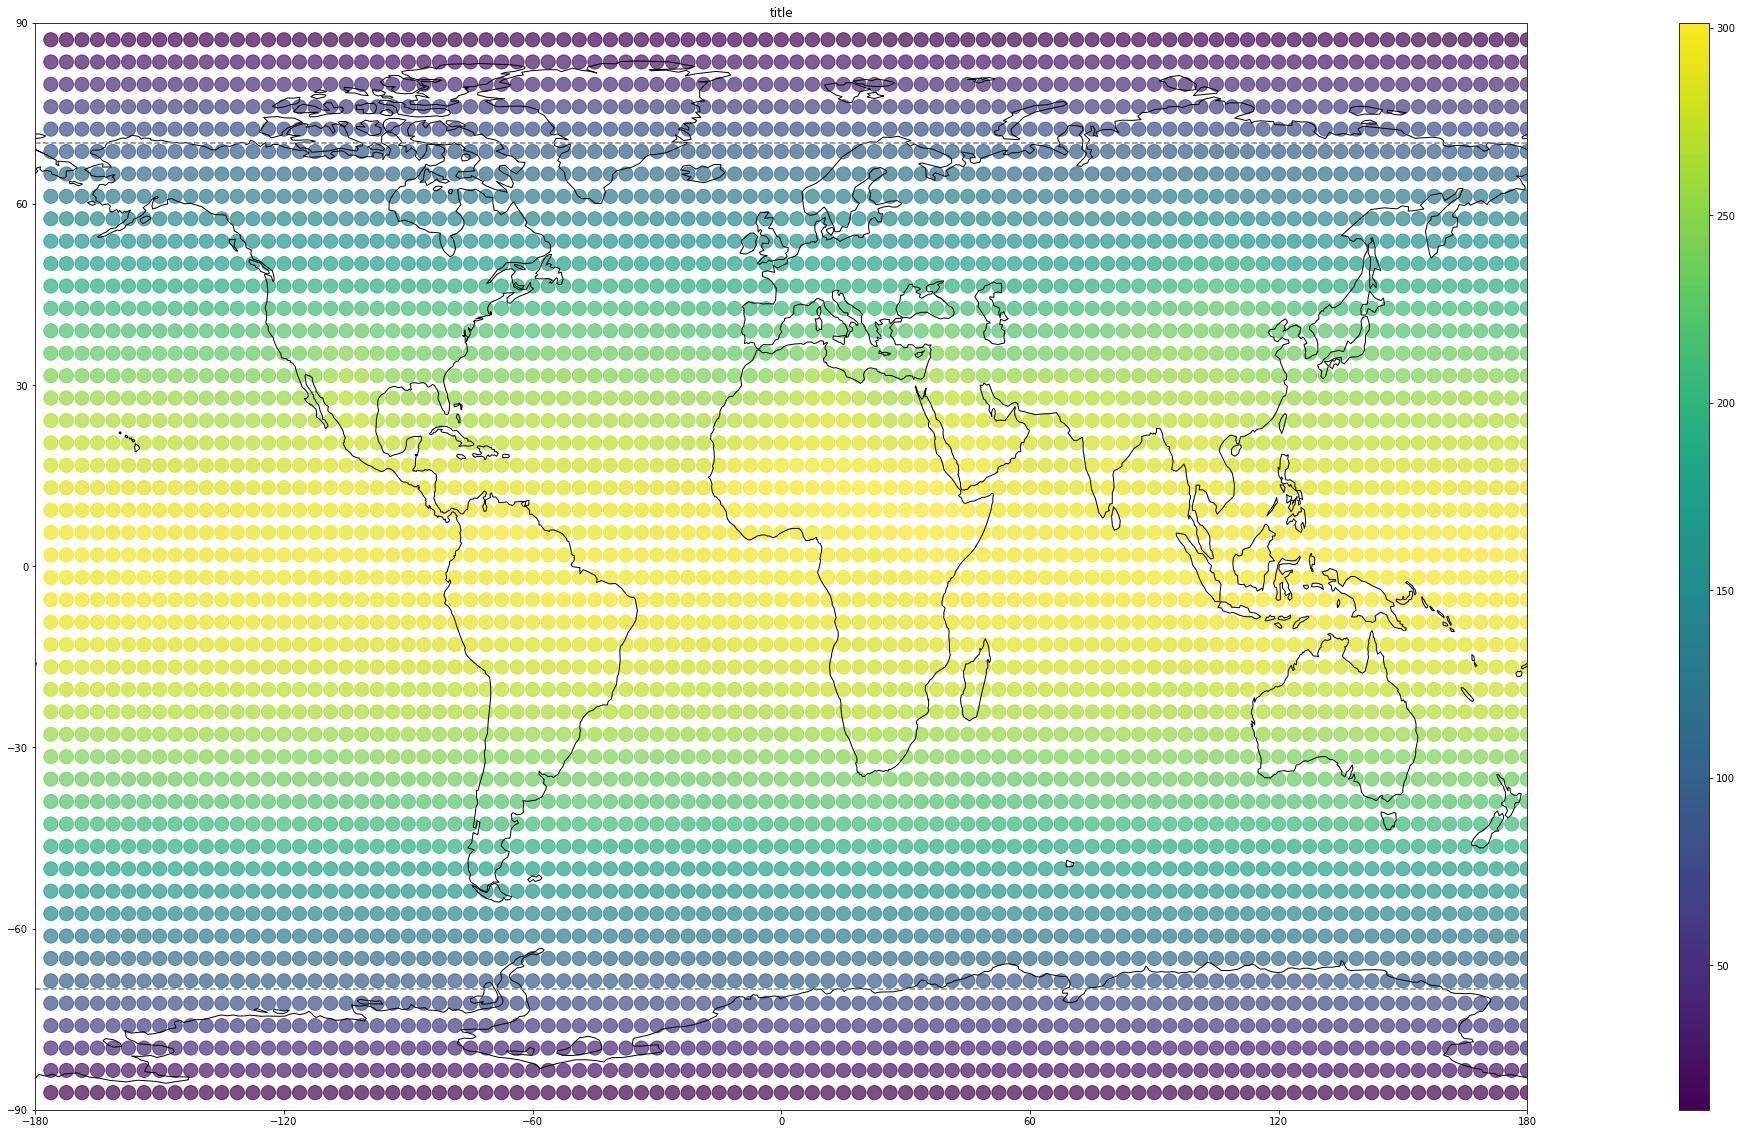

CPU times: user 22.3 s, sys: 457 ms, total: 22.7 s
Wall time: 22.5 s


In [63]:
%%time
plotter(df,cmap=plt.cm.viridis,title='title',markersize=200)

In [83]:
dflite = df[['latitude','longitude','weighted_temperature']].copy() #df.pivot('longitude', 'latitude')

In [84]:
hdfpivot = dflite.pivot('longitude', 'latitude')

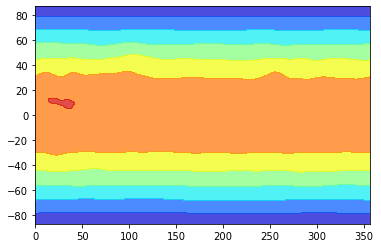

In [87]:
X=hdfpivot.columns.levels[1].values
Y=hdfpivot.index.values
Z=hdfpivot.values
Xi,Yi = np.meshgrid(X, Y)
plt.contourf(Yi, Xi, Z, alpha=0.7, cmap=plt.cm.jet,levels=5);
#plt.scatter(dflite.longitude,dflite.latitude,s=2)

TypeError: Input z must be 2D, not 1D

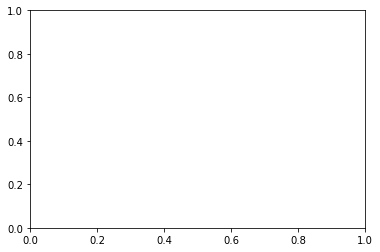

In [65]:
x = df.longitude
y = df.latitude
z = df.temperature
X,Y = np.meshgrid(x,y)
Z = z.T
plt.contourf(X,Y,Z,20,cmap='jet')
plt.colorbar()
plt.show()

In [107]:
1+1

2

In [340]:
    
#Parameters
root= '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/'
node = 'paper/100year/tmp_m5/'

header_directories = glob.glob(root+node+'*')


In [341]:
for h in header_directories:
    print(h)

/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_52_RN_m5
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_23_RN_m5
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_10_RN_m5
/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_10_SR_m5


In [343]:
glob.glob('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/*')

['/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_52_RN_m5',
 '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_23_RN_m5',
 '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_10_RN_m5',
 '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/tmp_m5/speedyone100yr_L2_10_SR_m5']